Link dataset https://www.kaggle.com/datasets/jeffheaton/is-a-block-structure-stable-or-unstable

In [1]:
import zipfile
import os
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from PIL import Image
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')


KeyboardInterrupt



# Caricamento Dataset da Kaggle

In [21]:
!pip install kaggle


In [22]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/ProgettoML/kaggle.json"

In [23]:
!kaggle datasets download -d jeffheaton/is-a-block-structure-stable-or-unstable

Traceback (most recent call last):
  File "/Users/stefanomorelli/Documents/Istruzione/Università/A.A 2023-2024/Machine Learning/ProgettoMl/.conda/bin/kaggle", line 7, in <module>
    from kaggle.cli import main
  File "/Users/stefanomorelli/Documents/Istruzione/Università/A.A 2023-2024/Machine Learning/ProgettoMl/.conda/lib/python3.10/site-packages/kaggle/__init__.py", line 3, in <module>
    from kaggle.api.kaggle_api_extended import KaggleApi
  File "/Users/stefanomorelli/Documents/Istruzione/Università/A.A 2023-2024/Machine Learning/ProgettoMl/.conda/lib/python3.10/site-packages/kaggle/api/__init__.py", line 6, in <module>
    from kaggle.api.kaggle_api_extended import KaggleApi
  File "/Users/stefanomorelli/Documents/Istruzione/Università/A.A 2023-2024/Machine Learning/ProgettoMl/.conda/lib/python3.10/site-packages/kaggle/api/kaggle_api_extended.py", line 258, in <module>
    class KaggleApi(KaggleApi):
  File "/Users/stefanomorelli/Documents/Istruzione/Università/A.A 2023-202

In [24]:


# Define the path to your zip file
file_path = "/content/is-a-block-structure-stable-or-unstable.zip" # Replace 'your_file.zip' with your file's name

# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/ProgettoML/Dati')  # Replace 'destination_folder' with your desired folder

FileNotFoundError: [Errno 2] No such file or directory: '/content/is-a-block-structure-stable-or-unstable.zip'

# Caricamento dati

In [7]:
import os
import numpy as np
import cv2
from tqdm import tqdm

import os
import numpy as np
import cv2

def load_data(data_dir):
    images = []
    labels = []

    for root, dirs, files in os.walk(data_dir):
        for label_dir in dirs:
            label = os.path.basename(label_dir)
            label_path = os.path.join(root, label_dir)
            print(f"Caricamento della cartella {label}...")
            for image_file in os.listdir(label_path):
                if image_file.endswith('.jpg'):
                    image_path = os.path.join(label_path, image_file)
                    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    if image is not None:
                        image = cv2.resize(image, (64, 64))
                        image = image.astype(np.float32) / 255.0
                        images.append(image)
                        labels.append(label)
            print(f"Caricamento della cartella {label} completato.")

    return np.array(images), np.array(labels)

# Esempio di utilizzo della funzione
train_dir = 'percorso/alla/cartella/train'
test_dir = 'percorso/alla/cartella/test'

train_images, train_labels = load_data(train_dir)
test_images, test_labels = load_data(test_dir)


# Esempio di utilizzo della funzione
train_dir = 'dataset/asl_alphabet_train'
test_dir = 'dataset/asl_alphabet_test'

train_images, train_labels = load_data(train_dir)
#test_images, test_labels = load_data(test_dir)


Caricamento della cartella asl_alphabet_train...
Caricamento della cartella asl_alphabet_train completato.
Caricamento della cartella R...
Caricamento della cartella R completato.
Caricamento della cartella U...
Caricamento della cartella U completato.
Caricamento della cartella I...
Caricamento della cartella I completato.
Caricamento della cartella N...
Caricamento della cartella N completato.
Caricamento della cartella G...
Caricamento della cartella G completato.
Caricamento della cartella Z...
Caricamento della cartella Z completato.
Caricamento della cartella T...
Caricamento della cartella T completato.
Caricamento della cartella S...
Caricamento della cartella S completato.
Caricamento della cartella A...
Caricamento della cartella A completato.
Caricamento della cartella F...
Caricamento della cartella F completato.
Caricamento della cartella O...
Caricamento della cartella O completato.
Caricamento della cartella H...
Caricamento della cartella H completato.
Caricamento della

In [37]:
train_images.shape

(69600, 64, 64)

In [38]:
from sklearn.model_selection import train_test_split

# Dividi il set di addestramento in train e validation
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42,stratify=train_labels)

In [41]:
train_images.shape

(55680, 64, 64)

In [ ]:
val_images.shape

(17400, 64, 64)

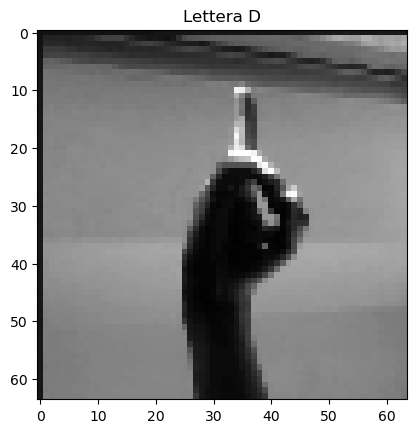

In [40]:
plt.imshow(train_images[1],cmap="grey")
plt.title(f"Lettera {train_labels[1]}")
plt.show()

In [13]:
from sklearn.preprocessing import LabelEncoder

# Inizializza il LabelEncoder
label_encoder = LabelEncoder()

# Codifica le etichette di addestramento
train_labels_encoded = label_encoder.fit_transform(train_labels)

In [195]:
val_labels_encoded = label_encoder.transform(val_labels)

In [263]:
df = pd.DataFrame(val_labels_encoded,columns=["label"])

In [265]:
df.label.value_counts()

label
7     480
16    480
23    480
28    480
1     480
13    480
14    480
22    480
27    480
4     480
20    480
12    480
8     480
19    480
2     480
5     480
17    480
0     480
11    480
15    480
6     480
18    480
10    480
21    480
3     480
26    480
9     480
25    480
24    480
Name: count, dtype: int64

# Numpy

In [ ]:
train_images_norm = np.array(train_images)/255

In [15]:
val_images_norm = np.array(val_images)/255

NameError: name 'val_images' is not defined

# Provo a visualizzare i dati 

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

In [250]:

train_images_norm = np.array(train_images)/255
val_images_norm = np.array(val_images)/255

In [24]:
train_images_vectorized = train_images_norm.reshape(len(train_images_norm), -1)

## Pca

In [27]:
pca = PCA(2)  # Specifica il numero di componenti principali desiderati
train_pca = pca.fit_transform(train_images_vectorized)

In [28]:
train_pca.shape

(69600, 2)

In [38]:
y_train.shape

(28842,)

In [46]:
train_pca_stable = train_pca[train_labels==1,:]

In [48]:
train_pca_unstable = train_pca[train_labels==0,:]

In [63]:
df = pd.DataFrame(train_pca,columns=["x","y"])

In [64]:
df.shape

(69600, 2)

In [66]:
labels = pd.DataFrame(train_labels,columns=["labels"])

In [67]:
df = pd.concat([df,labels],axis=1)

In [68]:
df.shape

(69600, 3)

In [69]:
df.columns

Index(['x', 'y', 'labels'], dtype='object')

In [71]:
df.head()

,x,y,labels
0,-0.003733,-0.036215,A
1,0.033081,0.021496,Y
2,-0.004233,-0.024579,Z
3,0.021291,0.033344,Z
4,0.018388,0.020552,H


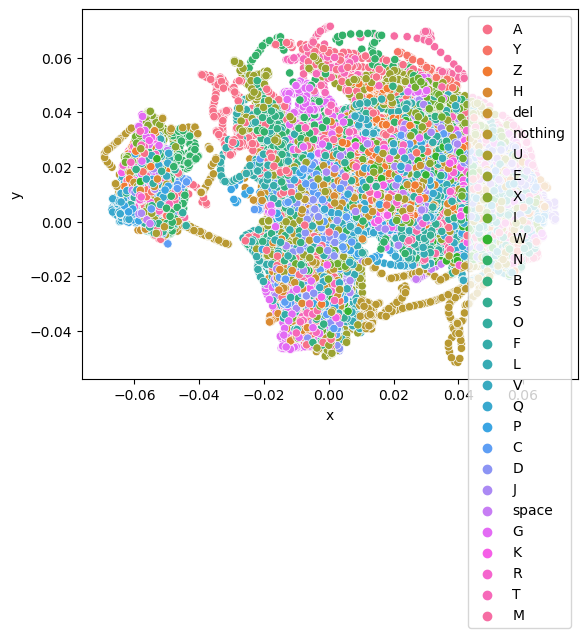

In [72]:
sns.scatterplot(data=df,x="x",y="y", hue='labels')

plt.legend()
plt.show()

## LDA

In [39]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis()
clf.fit(train_images_vectorized , y_train)

# primo tentativo

In [73]:
import tensorflow as tf
from tensorflow.keras import layers, models

2024-06-08 19:51:24.664133: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [273]:
from sklearn.preprocessing import LabelEncoder

# Inizializza il LabelEncoder
label_encoder = LabelEncoder()

# Codifica le etichette di addestramento
train_labels_encoded = label_encoder.fit_transform(train_labels)

In [278]:
model = models.Sequential([
    layers.Flatten(input_shape=(64,64)),  
    layers.Dense(256, activation='relu'),
    layers.Dense(29, activation='softmax')
])

In [279]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [280]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitora la loss sul set di validazione
    patience=3,  # Numero di epoche senza miglioramenti prima di interrompere l'addestramento
    restore_best_weights=True  # Ripristina i pesi migliori del modello
)

In [281]:
model.fit(train_images_norm, train_labels_encoded, epochs=100, batch_size=32,validation_data=(val_images_norm, val_labels_encoded),callbacks=[early_stopping_callback])

Epoch 1/100
1740/1740 [==============================] - 12s 6ms/step - loss: 3.1720 - accuracy: 0.1124 - val_loss: 2.9631 - val_accuracy: 0.1662
Epoch 2/100
1740/1740 [==============================] - 11s 6ms/step - loss: 2.8167 - accuracy: 0.1906 - val_loss: 2.7014 - val_accuracy: 0.2054
Epoch 3/100
1740/1740 [==============================] - 11s 6ms/step - loss: 2.6037 - accuracy: 0.2327 - val_loss: 2.5234 - val_accuracy: 0.2574
Epoch 4/100
1740/1740 [==============================] - 11s 6ms/step - loss: 2.4461 - accuracy: 0.2730 - val_loss: 2.3888 - val_accuracy: 0.2897
Epoch 5/100
1740/1740 [==============================] - 11s 6ms/step - loss: 2.3149 - accuracy: 0.3088 - val_loss: 2.2730 - val_accuracy: 0.3311
Epoch 6/100
1740/1740 [==============================] - 11s 6ms/step - loss: 2.2045 - accuracy: 0.3395 - val_loss: 2.1677 - val_accuracy: 0.3451
Epoch 7/100
1740/1740 [==============================] - 11s 6ms/step - loss: 2.1111 - accuracy: 0.3612 - val_loss: 2.0780 -

In [282]:
model.save("./Modelli/modello1")

INFO:tensorflow:Assets written to: ./Modelli/modello1/assets


# Secondo tentativo

# Secondo Tentativo PCA

In [118]:
from sklearn.decomposition import PCA

In [119]:
train_1d = train_images_norm.reshape(len(train_images_norm), -1)

In [121]:
pca = PCA(0.7)  # Specifica il numero di componenti principali desiderati
train_pca = pca.fit_transform(train_1d)

In [122]:
train_pca.shape

(69600, 6)

In [123]:
model_2 = models.Sequential([
    layers.Dense(6, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(29, activation='softmax')
])

In [124]:
model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [125]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitora la loss sul set di validazione
    patience=3,  # Numero di epoche senza miglioramenti prima di interrompere l'addestramento
    restore_best_weights=True  # Ripristina i pesi migliori del modello
)

In [126]:
model_2.fit(train_pca, train_labels_encoded, epochs=100, batch_size=32,validation_split=0.2,callbacks=[early_stopping_callback])

Epoch 1/100
1740/1740 [==============================] - 3s 2ms/step - loss: 3.1753 - accuracy: 0.0802 - val_loss: 3.0159 - val_accuracy: 0.1143
Epoch 2/100
1740/1740 [==============================] - 2s 1ms/step - loss: 2.9033 - accuracy: 0.1302 - val_loss: 2.7936 - val_accuracy: 0.1540
Epoch 3/100
1740/1740 [==============================] - 2s 1ms/step - loss: 2.7000 - accuracy: 0.1802 - val_loss: 2.6084 - val_accuracy: 0.2024
Epoch 4/100
1740/1740 [==============================] - 2s 1ms/step - loss: 2.5389 - accuracy: 0.2176 - val_loss: 2.4785 - val_accuracy: 0.2392
Epoch 5/100
1740/1740 [==============================] - 2s 1ms/step - loss: 2.4279 - accuracy: 0.2471 - val_loss: 2.3934 - val_accuracy: 0.2514
Epoch 6/100
1740/1740 [==============================] - 2s 1ms/step - loss: 2.3486 - accuracy: 0.2674 - val_loss: 2.3117 - val_accuracy: 0.2726
Epoch 7/100
1740/1740 [==============================] - 2s 1ms/step - loss: 2.2836 - accuracy: 0.2857 - val_loss: 2.2628 - val_ac

# Tentativo Pca 1

In [127]:
from sklearn.decomposition import PCA

In [128]:
train_1d = train_images_norm.reshape(len(train_images_norm), -1)

In [129]:
pca = PCA(0.8)  # Specifica il numero di componenti principali desiderati
train_pca = pca.fit_transform(train_1d)


In [130]:
model_1 = models.Sequential([
    layers.Dense(11, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(29, activation='softmax')
])

In [131]:
model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [132]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitora la loss sul set di validazione
    patience=3,  # Numero di epoche senza miglioramenti prima di interrompere l'addestramento
    restore_best_weights=True  # Ripristina i pesi migliori del modello
)

In [133]:
model_1.fit(train_pca, train_labels_encoded, epochs=100, batch_size=32,validation_data=(val_pca, val_labels_encoded),callbacks=[early_stopping_callback])

Epoch 1/100
1740/1740 [==============================] - 3s 1ms/step - loss: 2.9745 - accuracy: 0.1295 - val_loss: 2.7666 - val_accuracy: 0.1627
Epoch 2/100
1740/1740 [==============================] - 2s 1ms/step - loss: 2.5985 - accuracy: 0.1999 - val_loss: 2.4386 - val_accuracy: 0.2338
Epoch 3/100
1740/1740 [==============================] - 2s 1ms/step - loss: 2.3150 - accuracy: 0.2660 - val_loss: 2.2010 - val_accuracy: 0.2821
Epoch 4/100
1740/1740 [==============================] - 2s 1ms/step - loss: 2.1212 - accuracy: 0.3198 - val_loss: 2.0526 - val_accuracy: 0.3273
Epoch 5/100
1740/1740 [==============================] - 2s 1ms/step - loss: 1.9765 - accuracy: 0.3586 - val_loss: 1.9086 - val_accuracy: 0.3772
Epoch 6/100
1740/1740 [==============================] - 2s 1ms/step - loss: 1.8477 - accuracy: 0.3919 - val_loss: 1.7833 - val_accuracy: 0.4157
Epoch 7/100
1740/1740 [==============================] - 2s 1ms/step - loss: 1.7326 - accuracy: 0.4247 - val_loss: 1.6813 - val_ac

# Tentativo Pca 3

In [134]:
from sklearn.decomposition import PCA

In [135]:
train_1d = train_images_norm.reshape(len(train_images_norm), -1)
val_1d = val_images.reshape(len(val_images_norm), -1)

In [220]:
pca = PCA(0.9)  # Specifica il numero di componenti principali desiderati
train_pca = pca.fit_transform(train_1d)

In [221]:
val_pca = pca.transform(val_1d)

In [222]:
model_1 = models.Sequential([
    layers.Dense(40, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(29, activation='softmax')
])

In [224]:
model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [140]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitora la loss sul set di validazione
    patience=3,  # Numero di epoche senza miglioramenti prima di interrompere l'addestramento
    restore_best_weights=True  # Ripristina i pesi migliori del modello
)

In [225]:
model_1.fit(train_pca, train_labels_encoded, epochs=100, batch_size=32,validation_data=(val_pca, val_labels_encoded),callbacks=[early_stopping_callback])

Epoch 1/100
1740/1740 [==============================] - 4s 2ms/step - loss: 2.7452 - accuracy: 0.1677 - val_loss: 1567.7046 - val_accuracy: 0.0419
Epoch 2/100
1740/1740 [==============================] - 2s 1ms/step - loss: 2.0971 - accuracy: 0.3173 - val_loss: 3904.0581 - val_accuracy: 0.0470
Epoch 3/100
1740/1740 [==============================] - 2s 1ms/step - loss: 1.7355 - accuracy: 0.4212 - val_loss: 5463.3076 - val_accuracy: 0.0540
Epoch 4/100
1740/1740 [==============================] - 2s 1ms/step - loss: 1.5055 - accuracy: 0.4913 - val_loss: 6973.2988 - val_accuracy: 0.0527


# Tentativo Pca 3

In [142]:
from sklearn.decomposition import PCA

In [227]:
train_1d = train_images_norm.reshape(len(train_images_norm), -1)
val_1d = val_images.reshape(len(val_images_norm), -1)

In [228]:
pca = PCA(0.95)  # Specifica il numero di componenti principali desiderati
train_pca = pca.fit_transform(train_1d)

In [230]:
val_pca = pca.transform(val_1d)

In [146]:
train_pca.shape

(69600, 111)

In [175]:
model_1 = models.Sequential([
    layers.Dense(111, activation='tanh'),
    layers.Dense(256, activation='relu6'),
    layers.Dense(256, activation='tanh'),
    layers.Dense(29, activation='softmax')
])

In [176]:
model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [158]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitora la loss sul set di validazione
    patience=3,  # Numero di epoche senza miglioramenti prima di interrompere l'addestramento
    restore_best_weights=True  # Ripristina i pesi migliori del modello
)

In [177]:
model_1.fit(train_pca, train_labels_encoded, epochs=100, batch_size=32,validation_split=0.2,callbacks=[early_stopping_callback])

Epoch 1/100
1740/1740 [==============================] - 3s 1ms/step - loss: 2.2657 - accuracy: 0.2741 - val_loss: 1.6949 - val_accuracy: 0.4177
Epoch 2/100
1740/1740 [==============================] - 2s 1ms/step - loss: 1.4716 - accuracy: 0.4957 - val_loss: 1.2861 - val_accuracy: 0.5537
Epoch 3/100
1740/1740 [==============================] - 2s 1ms/step - loss: 1.1198 - accuracy: 0.6169 - val_loss: 1.0089 - val_accuracy: 0.6517
Epoch 4/100
1740/1740 [==============================] - 2s 1ms/step - loss: 0.8741 - accuracy: 0.7027 - val_loss: 0.7629 - val_accuracy: 0.7486
Epoch 5/100
1740/1740 [==============================] - 2s 1ms/step - loss: 0.7001 - accuracy: 0.7617 - val_loss: 0.6323 - val_accuracy: 0.7858
Epoch 6/100
1740/1740 [==============================] - 2s 1ms/step - loss: 0.5705 - accuracy: 0.8057 - val_loss: 0.5391 - val_accuracy: 0.8150
Epoch 7/100
1740/1740 [==============================] - 3s 1ms/step - loss: 0.4807 - accuracy: 0.8349 - val_loss: 0.4451 - val_ac

In [178]:
model_1.save("./Modelli/modello_pca3")

INFO:tensorflow:Assets written to: ./Modelli/modello_pca3/assets


In [226]:
loaded_model = tf.keras.models.load_model('./Modelli/modello_pca3')

In [231]:
loss, accuracy = loaded_model.evaluate(val_pca, val_labels_encoded)
print(f'Accuracy del modello caricato: {accuracy}')

435/435 [==============================] - 1s 1ms/step - loss: 29.6106 - accuracy: 0.0565
Accuracy del modello caricato: 0.0564655177295208


# Tuning degli iperparametri

In [192]:
train_1d = train_images_norm.reshape(len(train_images_norm), -1)
val_1d = val_images.reshape(len(val_images_norm), -1)

In [193]:
val_1d.shape

(13920, 4096)

In [191]:
train_1d.shape

(55680, 4096)

In [179]:
pca = PCA(0.95)  # Specifica il numero di componenti principali desiderati
train_pca = pca.fit_transform(train_1d)

In [194]:
val_pca = pca.transform(val_1d)

In [180]:
model_3_pca = models.Sequential([
    layers.Dense(111, activation='tanh'),
    layers.Dense(256, activation='relu6'),
    layers.Dense(256, activation='tanh'),
    layers.Dense(29, activation='softmax')
])

In [181]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitora la loss sul set di validazione
    patience=3,  # Numero di epoche senza miglioramenti prima di interrompere l'addestramento
    restore_best_weights=True  # Ripristina i pesi migliori del modello
)

In [209]:
from bayes_opt import BayesianOptimization
def create_model(dense_units1, dense_units2,learning_rate):
    model = models.Sequential([
        layers.Dense(111, activation='tanh'),
        layers.Dense(int(dense_units2), activation='relu6'),
        layers.Dense(int(dense_units2), activation='tanh'),
        layers.Dense(29, activation='softmax')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

def objective(dense_units1, dense_units2, learning_rate):
    model = create_model(dense_units1, dense_units2,learning_rate)
    
    history = model.fit(train_pca, train_labels_encoded,
                        validation_data=(val_pca, val_labels_encoded),
                        epochs=10,
                        batch_size=32,
                        verbose=2)
    
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

# Imposta i parametri di ricerca
pbounds = {
    'learning_rate':(0.0001,0.001),
    'dense_units1': (128, 512),
    'dense_units2': (128, 512),
    
}
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=42,
)

# Avvia l'ottimizzazione
optimizer.maximize(init_points=5, n_iter=10)

# Visualizza i migliori parametri trovati
print("Best hyperparameters: ", optimizer.max)

|   iter    |  target   | dense_... | dense_... | learni... |
-------------------------------------------------------------
Epoch 1/10
2175/2175 - 7s - loss: 2.0635 - accuracy: 0.3289 - val_loss: 36.9775 - val_accuracy: 0.0414 - 7s/epoch - 3ms/step
Epoch 2/10
2175/2175 - 4s - loss: 1.2388 - accuracy: 0.5765 - val_loss: 43.0332 - val_accuracy: 0.0419 - 4s/epoch - 2ms/step
Epoch 3/10
2175/2175 - 4s - loss: 0.8566 - accuracy: 0.7089 - val_loss: 43.4309 - val_accuracy: 0.0421 - 4s/epoch - 2ms/step
Epoch 4/10
2175/2175 - 4s - loss: 0.6261 - accuracy: 0.7861 - val_loss: 43.1053 - val_accuracy: 0.0451 - 4s/epoch - 2ms/step
Epoch 5/10
2175/2175 - 4s - loss: 0.4778 - accuracy: 0.8368 - val_loss: 44.0312 - val_accuracy: 0.0472 - 4s/epoch - 2ms/step
Epoch 6/10
2175/2175 - 4s - loss: 0.3715 - accuracy: 0.8726 - val_loss: 44.9108 - val_accuracy: 0.0464 - 4s/epoch - 2ms/step
Epoch 7/10
2175/2175 - 4s - loss: 0.2956 - accuracy: 0.8977 - val_loss: 41.5554 - val_accuracy: 0.0542 - 4s/epoch - 2ms/step
E

KeyboardInterrupt: 

In [211]:
model_1 = create_model(256.1,256.3,0.001086515132249486)

In [212]:
model_1.fit(train_pca, train_labels_encoded, epochs=100, batch_size=32,validation_data=(val_pca, val_labels_encoded),callbacks=[early_stopping_callback])

Epoch 1/100
2175/2175 [==============================] - 3s 1ms/step - loss: 2.0879 - accuracy: 0.3188 - val_loss: 19.2276 - val_accuracy: 0.0540
Epoch 2/100
2175/2175 [==============================] - 3s 1ms/step - loss: 1.2833 - accuracy: 0.5583 - val_loss: 22.9796 - val_accuracy: 0.0458
Epoch 3/100
2175/2175 [==============================] - 3s 1ms/step - loss: 0.9209 - accuracy: 0.6853 - val_loss: 22.2298 - val_accuracy: 0.0490
Epoch 4/100
2175/2175 [==============================] - 3s 1ms/step - loss: 0.6833 - accuracy: 0.7664 - val_loss: 23.6641 - val_accuracy: 0.0435


# CNN copiata

In [232]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [245]:
train_images_norm_r = train_images_norm.reshape(-1, 64, 64, 1)
val_images_norm_r = val_images_norm.reshape(-1, 64, 64, 1)

In [266]:
from tensorflow.keras.callbacks import Callback
import numpy as np

class CustomShuffleCallback(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        # Mescola gli indici dei dati di addestramento
        shuffle_indices = np.random.permutation(len(self.model.train_images))

        # Applica la mescolatura sia alle immagini che alle et


In [270]:
model = Sequential()

model = models.Sequential()
# 1st convolution layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(64,64,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# 2nd convolution layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# 3rd convolution layer
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# fully-connected layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(29, activation='softmax'))

model.summary()

Model: "sequential_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_96 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_71 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_46 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_97 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                     

In [271]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [253]:
train_images_norm.shape

(55680, 64, 64)

In [272]:
model.fit(train_images_norm, train_labels_encoded, epochs=100, batch_size=32,validation_data=(val_images_norm, val_labels_encoded),callbacks=[early_stopping_callback],shuffle=True)

Epoch 1/100
1740/1740 [==============================] - 206s 118ms/step - loss: 0.7562 - accuracy: 0.7704 - val_loss: 10.9382 - val_accuracy: 0.3045
Epoch 2/100
1740/1740 [==============================] - 206s 118ms/step - loss: 0.1200 - accuracy: 0.9615 - val_loss: 7.9286 - val_accuracy: 0.1398
Epoch 3/100
 632/1740 [=========>....................] - ETA: 2:01 - loss: 0.0682 - accuracy: 0.9800

KeyboardInterrupt: 

# Tentativo 3

In [55]:
type(train_images[0])

numpy.ndarray

applico un filtro orizziontale

In [96]:
from scipy import ndimage

In [108]:
def filtro_passa_alto(img):
    lowpass = ndimage.gaussian_filter(img, 2)
    img_filtrata = img - lowpass
    return img_filtrata

In [109]:
filtrata = filtro_passa_alto(train_images[0])

Text(0.5, 1.0, 'Filtro applicati')

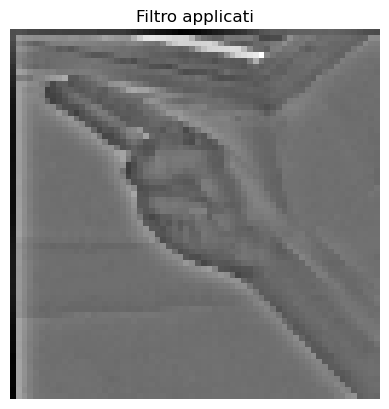

In [110]:
plt.imshow(filtrata,cmap="grey")
plt.axis(False)
plt.title("Filtro applicati")

In [111]:
train_images_filtrate = [filtro_passa_alto(immagine) for immagine in train_images]

In [81]:
train_images_filtrate_h= [cv2.Sobel(immagine,ddepth=-1,dx=0,dy=1 ) for immagine in train_images]

applico un filtro verticale

In [82]:
train_images_filtrate_v = [cv2.Sobel(immagine,ddepth=-1,dx=1,dy=0 ) for immagine in train_images]

mostro un immagine di test per ciascun filtro

Text(0.5, 1.0, 'Filtro applicati')

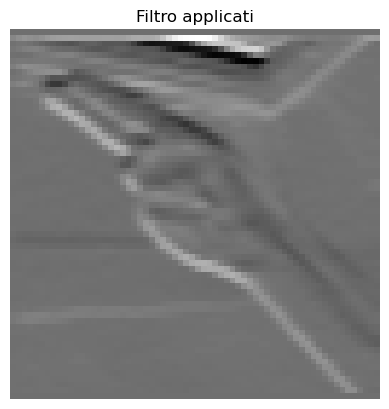

In [83]:
plt.imshow(train_images_filtrate_h[0],cmap="grey")
plt.axis(False)
plt.title("Filtro applicati")

Text(0.5, 1.0, 'Filtro verticale')

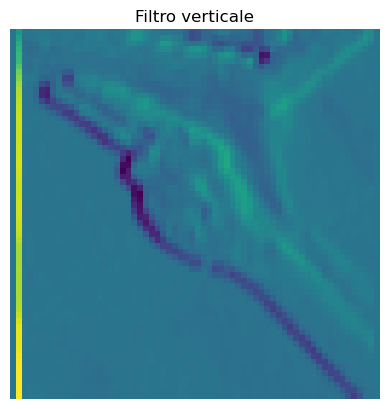

In [84]:
plt.imshow(train_images_filtrate_v[0])
plt.axis(False)
plt.title("Filtro verticale")

combino le immagini

In [85]:
train_images_filtrate = []
for immagine1, immagine2 in zip(train_images_filtrate_v, train_images_filtrate_h):
    # Sovrapponi le immagini (la seconda immagine viene sovrapposta sulla prima)
    combinazione = cv2.addWeighted(immagine1, 0.5, immagine2, 0.5, 0)
    train_images_filtrate.append(combinazione)

Text(0.5, 1.0, 'Filtri combinati')

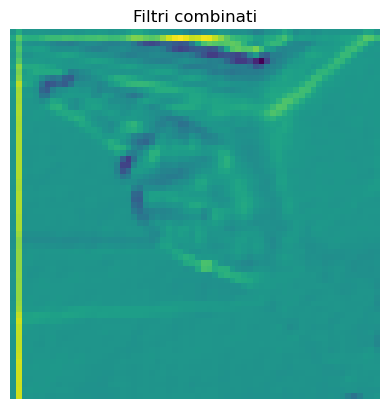

In [86]:
plt.imshow(train_images_filtrate[0])
plt.axis(False)
plt.title("Filtri combinati")

In [87]:
train_images_filtrate[0].shape

(64, 64)

In [114]:
model_3 = models.Sequential([
    layers.Flatten(input_shape=(64,64)),  

     layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(29, activation='softmax')
])

In [115]:
model_3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

normalizzo le immagini

In [116]:
train_images_filtrate_norm = np.array(train_images_filtrate)/255

In [117]:
model_3.fit(train_images_filtrate_norm, train_labels_encoded, epochs=30, batch_size=32, validation_split=0.2,callbacks=early_stopping_callback)

Epoch 1/30
1392/1392 [==============================] - 13s 9ms/step - loss: 3.3677 - accuracy: 0.0337 - val_loss: 3.3676 - val_accuracy: 0.0336
Epoch 2/30
1392/1392 [==============================] - 10s 7ms/step - loss: 3.3676 - accuracy: 0.0356 - val_loss: 3.3677 - val_accuracy: 0.0323
Epoch 3/30
1392/1392 [==============================] - 10s 7ms/step - loss: 3.3676 - accuracy: 0.0338 - val_loss: 3.3676 - val_accuracy: 0.0336
Epoch 4/30
 617/1392 [============>.................] - ETA: 5s - loss: 3.3673 - accuracy: 0.0340

KeyboardInterrupt: 

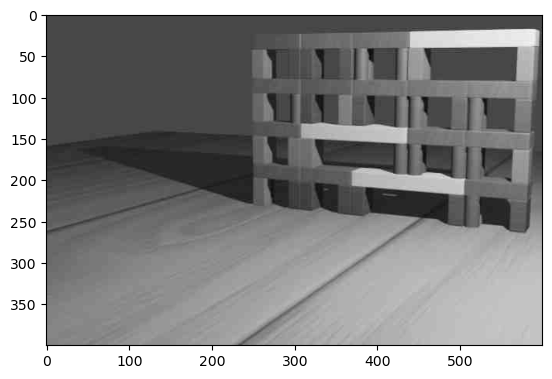

In [39]:
plt.imshow(train_images[0],cmap="grey")

In [40]:
from rembg import remove 



In [41]:
result_image = remove(train_images[0])

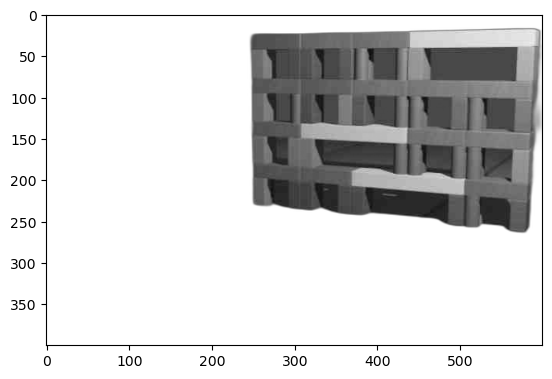

In [42]:
plt.imshow(result_image)

In [43]:
def focusToContent(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_ = 255*(img < 128).astype(np.uint8) 
    coords = cv2.findNonZero(img_) # Find all non-zero points (text)
    x, y, w, h = cv2.boundingRect(coords) # Find minimum spanning bounding box
    
    rect = img[y:y+h, x:x+w] # Crop the image - note we do this on the original image
    rect_originalSized = cv2.resize(rect,(img.shape))
    return rect_originalSized

In [44]:
focused = focusToContent(result_image)

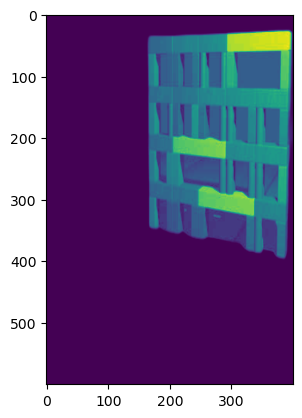

In [45]:
plt.imshow(focused)

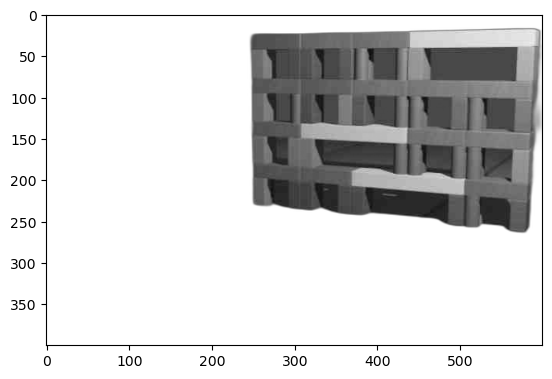

In [46]:
plt.imshow(result_image)

In [47]:
def remove_bg(images):
  image_list =[]
  
  for index in tqdm(range(0,len(images)), desc="Caricamento immagini"):
    
    image_list.append(remove(images[index]))
  return image_list

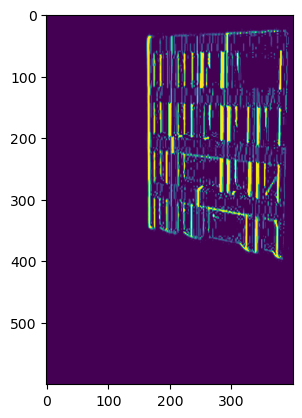

In [48]:
result_image_h = cv2.Scharr(focused,ddepth=-1,dx=1,dy=0 )
plt.imshow(result_image_h)

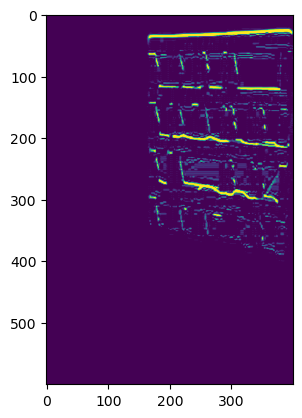

In [49]:
result_image_v = cv2.Scharr(focused,ddepth=-1,dx=0,dy=1 )
plt.imshow(result_image_v)

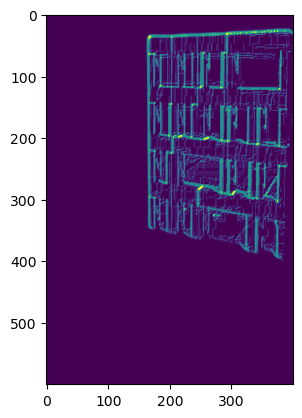

In [50]:
combinazione = cv2.addWeighted(result_image_h, 0.5, result_image_v, 0.5, 0)
plt.imshow(combinazione)

In [51]:
train_images_nobg = remove_bg(train_images)

Caricamento immagini:   0%|          | 25/28842 [00:32<10:26:42,  1.30s/it]


KeyboardInterrupt: 

# CNN

In [46]:
import tensorflow as tf
from tensorflow.keras import layers, models


model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(29,activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model.fit(train_images_norm_reshape, train_labels_encoded, epochs=30, batch_size=32,validation_split=0.2,callbacks=[early_stopping_callback])


Epoch 1/30
1740/1740 [==============================] - 204s 117ms/step - loss: 1.7389 - accuracy: 0.4668 - val_loss: 1.4097 - val_accuracy: 0.5478
Epoch 2/30
1740/1740 [==============================] - 203s 117ms/step - loss: 0.8896 - accuracy: 0.7067 - val_loss: 2.0539 - val_accuracy: 0.4935
Epoch 3/30
1740/1740 [==============================] - 188s 108ms/step - loss: 0.6352 - accuracy: 0.7859 - val_loss: 3.6674 - val_accuracy: 0.3957
Epoch 4/30
1740/1740 [==============================] - 200s 115ms/step - loss: 0.5013 - accuracy: 0.8296 - val_loss: 9.8819 - val_accuracy: 0.2624


# CNN con filtri

In [61]:
train_images_filtrate_h = [cv2.Scharr(immagine,ddepth=-1,dx=0,dy=1 ) for immagine in train_images]

In [62]:
train_images_filtrate_v = [cv2.Scharr(immagine,ddepth=-1,dx=1,dy=0 ) for immagine in train_images]

In [63]:
train_images_filtrate = []
for immagine1, immagine2 in zip(train_images_filtrate_v, train_images_filtrate_h):
    # Sovrapponi le immagini (la seconda immagine viene sovrapposta sulla prima)
    combinazione = cv2.addWeighted(immagine1, 0.5, immagine2, 0.5, 0)
    train_images_filtrate.append(combinazione)

In [66]:
train_images_resize = np.array([cv2.resize(immagine, (75, 50)) for immagine in train_images_filtrate])
train_images_norm = np.array(train_images_resize)/255
val_images_resize = np.array([cv2.resize(immagine, (75, 50)) for immagine in val_images])
val_images_norm = np.array(val_images_resize)/255

In [111]:
import tensorflow as tf
from tensorflow.keras import layers, models



model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3, 3), activation='relu', input_shape=(50, 75, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))


model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.fit(train_images_norm , y_train, epochs=5, batch_size=256,validation_split=0.2)




ValueError: Input 0 of layer "conv3d" is incompatible with the layer: expected min_ndim=5, found ndim=4. Full shape received: (None, 50, 75, 1)